# Preparing the data for Fibers Case 1

Load main libraries, set paths and adjust plotting theme (optional)

In [12]:
from pathlib import Path
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.background = 'white'
pv.global_theme.color = "beige"
pv.global_theme.show_edges = True
pv.global_theme.window_size = [800, 400]

STATICS_DIR = Path("../../../../_static")
HALF_ELLIPSOID_FILEPATH = STATICS_DIR / "hex_half_ellipsoid.vtk"

### Load the Mesh

In this examples, we are simply interested in manipulating the FEB file and not the mesh itself, therefore we will be used pre-defined mesh.
If you wish to create the mesh using python, we recommend using the pyvista or the gmsh and pygmsh libraries. 

Number of nodes: 1828
Number of cells: 1296


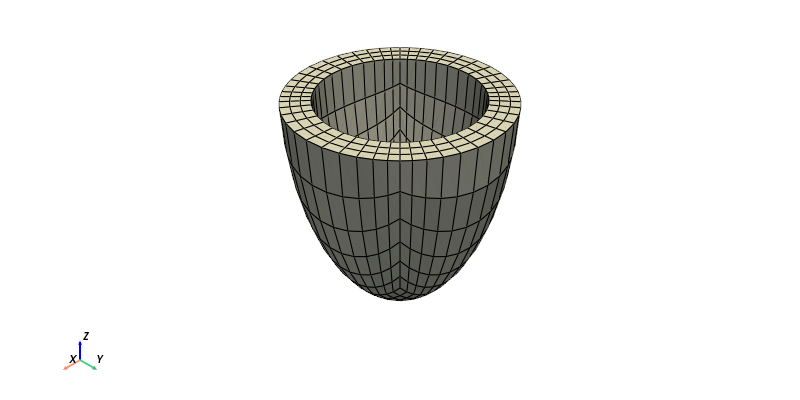

In [13]:
# Load the mesh
grid = pv.read(HALF_ELLIPSOID_FILEPATH)
print(f"Number of nodes: {grid.n_points}")
print(f"Number of cells: {grid.n_cells}")
grid.plot(color="beige")

### Prepare the data (find node ids of interest)

#### Find node ids for boundary conditions

In [14]:
# For the "top" nodes
grid_nodes = grid.points
z_max = grid_nodes[:, 2].max()
top_nodes_indices = np.where(abs(grid_nodes[:, 2] - z_max) < 1e-6)[0]

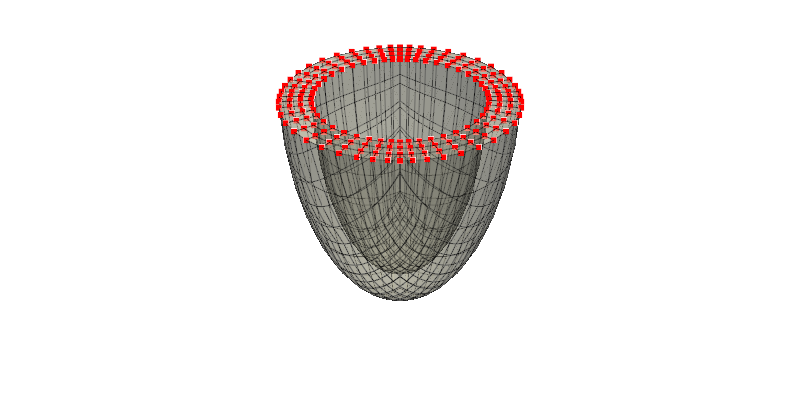

In [15]:
plotter = pv.Plotter()
plotter.add_mesh(grid, color="beige", opacity=0.5)
plotter.add_points(grid.points[top_nodes_indices], color="red", point_size=6)
plotter.show()

### Create surface to apply surface load

In [16]:
# Extract the surface from the unstructured grid
surf_grid: pv.PolyData = grid.extract_surface()
# Compute surface normals for the extracted surface
surf_normals = surf_grid.compute_normals(cell_normals=True, point_normals=False)
# Convert the PolyData (surface) grid into an UnstructuredGrid
surf_grid = surf_grid.cast_to_unstructured_grid()
# Extract cell indices for a specific cell type, here QUAD
surf_cells: np.ndarray = surf_grid.cells_dict[pv.CellType.QUAD]
# Calculate the center points of the surface cells
surf_centers = surf_grid.copy().cell_centers().points
# Get the normals calculated in Step 2
surf_normals = surf_normals["Normals"]
# Calculate the centroid of the original mesh
centroid = np.mean(grid.points, axis=0)
# Compute vectors from surface centers to the centroid
vecs = surf_centers - centroid
# Compute the dot product of the vectors and the normals
dots = np.sum(vecs * surf_normals, axis=1)
# Calculate the angle between each vector and its corresponding normal
angles = np.arccos(dots / (np.linalg.norm(vecs, axis=1) * np.linalg.norm(surf_normals, axis=1)))
# Select surfaces that have an angle greater than 90 degrees with respect to the centroid
mask = angles > np.pi / 2
# Extract cells that are identified as 'inner surfaces' based on the mask
selected_load_surface = surf_grid.copy().extract_cells(mask)
# Map the node indices from the selected inner surface cells back to the original mesh
# Mapping from the selected surface to the extracted surface
first_map = selected_load_surface["vtkOriginalPointIds"]
# Mapping from the extracted surface to the original block mesh
second_map = surf_grid["vtkOriginalPointIds"]
# Reconstruct surface connectivity for the selected inner surfaces
load_surface_connectivity = selected_load_surface.cells_dict[pv.CellType.QUAD]
# Adjust connectivity indices to refer back to the original mesh
for i, cell in enumerate(load_surface_connectivity):
    # Adjust each cell's indices to match the original grid's indexing
    cell = [first_map[j] for j in cell]
    load_surface_connectivity[i] = [second_map[j] for j in cell]

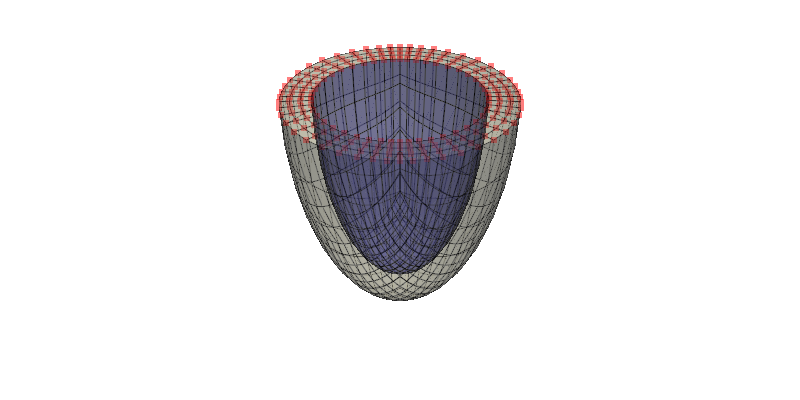

In [17]:
plotter = pv.Plotter()
plotter.add_mesh(grid, color="beige", opacity=0.5)
plotter.add_points(grid.points[top_nodes_indices], color="red", point_size=6, opacity=0.5)
plotter.add_mesh(selected_load_surface, color="blue", show_edges=True, opacity=0.5)
plotter.show()

### Create a fibers field

In [18]:
# Calculate cell centers
cell_centers = grid.cell_centers()

# Get the coordinates of the cell centers
points = cell_centers.points

# Compute the base tangential vectors assuming a clockwise direction
# The tangential base vector at any point on the xy-plane is given by [-y, x, 0]
tangential_vectors = np.column_stack((-points[:, 1], points[:, 0], np.zeros(points.shape[0])))

# Normalize these vectors
norms = np.linalg.norm(tangential_vectors, axis=1)
tangential_vectors = tangential_vectors / norms[:, None]

# Compute the axis for rotating these vectors upwards by 30 degrees
# This axis is simply the z-axis for this transformation
rotation_axis = np.array([0, 0, 1])

# Define the angle of rotation upwards (30 degrees)
angle = np.radians(30)
cos_angle = np.cos(angle)
sin_angle = np.sin(angle)

# Rodrigues' rotation formula to tilt vectors upwards
K = np.array([
    [0, -rotation_axis[2], rotation_axis[1]],
    [rotation_axis[2], 0, -rotation_axis[0]],
    [-rotation_axis[1], rotation_axis[0], 0]
])

fibers = np.array([
    v * cos_angle + np.cross(rotation_axis, v) * sin_angle + rotation_axis * np.dot(rotation_axis, v) * (1 - cos_angle)
    for v in tangential_vectors
])

# Add the computed fiber field to the cell data
cell_centers['Fibers'] = fibers

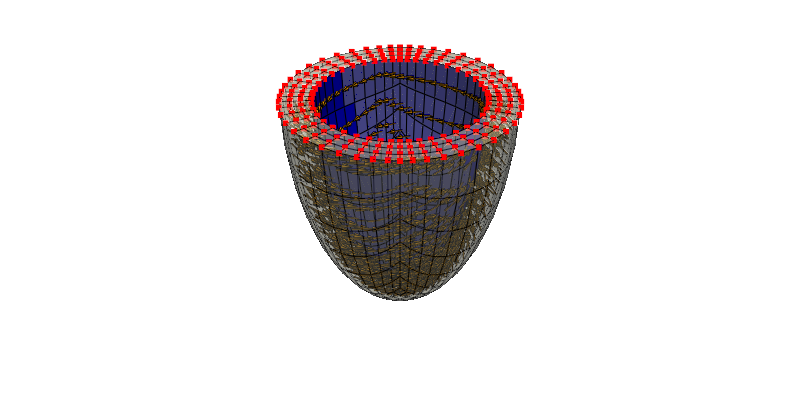

In [20]:
plotter = pv.Plotter()
plotter.add_mesh(grid, color="beige", opacity=0.5)
plotter.add_points(grid.points[top_nodes_indices], color="red", point_size=6)
plotter.add_mesh(selected_load_surface, color="blue", point_size=6)
plotter.add_arrows(grid.cell_centers().points, fibers, mag=0.1, color="orange")
plotter.show()

### Saving as a multiblock

In [21]:
# Add boundary and ground ids as field data
grid.field_data["boundary_ids"] = top_nodes_indices
# Add the load surface connectivity as field data
selected_load_surface.field_data["load_surface_connectivity"] = load_surface_connectivity
# Add fibers as cell data
grid.cell_data["Fibers"] = fibers

In [22]:
mb = pv.MultiBlock(
    {
        "grid": grid,
        "selected_load_surface": selected_load_surface
    }
)

In [23]:
mb.save(STATICS_DIR / "hex_ellipsoid_multiblock_fibers_case_1.vtm")